# General imports

In [1]:
import geopandas as gpd
import numpy as np
import pprint
import pyproj
import pyvista
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

from geograypher.cameras.derived_cameras import MetashapeCameraSet
from geograypher.cameras.segmentor import SegmentorPhotogrammetryCameraSet
from geograypher.meshes import TexturedPhotogrammetryMesh
from geograypher.predictors.derived_segmentors import LookUpSegmentor
from geograypher.utils.prediction_metrics import compute_and_show_cf, compute_comprehensive_metrics
from geograypher.utils.indexing import find_argmax_nonzero_value
from geograypher.utils.visualization import show_segmentation_labels
from geograypher.constants import (
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_PREDICTED_LABELS_FOLDER,
    EXAMPLE_DTM_FILE,
    EXAMPLE_AGGREGATED_FACE_LABELS_FILE,
    EXAMPLE_IDS_TO_LABELS,
    EXAMPLE_MESH_CRS,
    TEN_CLASS_VIS_KWARGS,
)

# Processing parameters

In [2]:
# Skip re-computing the aggregation and use a saved version
USE_CACHED_AGGREGATION = False
AGGREGATE_IMAGE_SCALE = 0.25  # Aggregate images at this scale resolution

IDS_TO_LABELS = {0: "BO", 1: "CR", 2: "SH", 3: "HE", 4: "GR", 5: "LO", 6: "MA", 7: "SK"}
CAMERAS_FILENAME = Path("/ofo-share/scratch-eric/tmp/automate-test-360-st0077_SHIFT/automate-test-360-st0077_cameras.xml")
MESH_FILENAME = Path("/ofo-share/scratch-eric/tmp/automate-test-360-st0077_SHIFT/automate-test-360-st0077_mesh_0-1.ply")
MESH_CRS = 26910
IMAGE_FOLDER = Path("/ofo-share/repos-david/under-canopy-mapping/data/data_to_annotate/2024-ofo-gopro__st-0077-gopro-360-photos-timelapse-subset/")
ORIGINAL_IMAGE_FOLDER = Path("/ofo-share/scratch-eric/exp360/2024-ofo-gopro__st-0077-gopro-360-photos-timelapse/")
PREDICTED_IMAGE_LABELS_FOLDER = Path("/ofo-share/repos-david/under-canopy-mapping/data/predictions/2024-ofo-gopro__st-0077-gopro-360-photos-timelapse-subset")
AGGREGATED_FACE_LABELS_FILE = Path("/ofo-share/scratch-eric/tmp/aggregated_face_labels.npy")
VIS_MESH_PATH = Path("/ofo-share/scratch-eric/tmp/labeled_mesh.ply")
VIS_PCD_PATH = Path("/ofo-share/scratch-eric/tmp/trunk_cloud.ply")
DTM_FILE = Path("/ofo-share/scratch-eric/tmp/automate-test-360-st0077_SHIFT/automate-test-360-st0077_dtm-ptcloud.tif")
PCD_FILE = Path("/ofo-share/scratch-eric/tmp/automate-test-360-st0077_SHIFT/automate-test-360-st0077_points.ply")

# Load the camera set

In [3]:
# Create camera set
camera_set = MetashapeCameraSet(
    camera_file=CAMERAS_FILENAME,
    image_folder=IMAGE_FOLDER,
    original_image_folder=ORIGINAL_IMAGE_FOLDER,
)

# Load the mesh

In [4]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    input_CRS=MESH_CRS,
    IDs_to_labels=IDS_TO_LABELS,
    ROI=camera_set,
    ROI_buffer_meters=0.0,
)

Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture


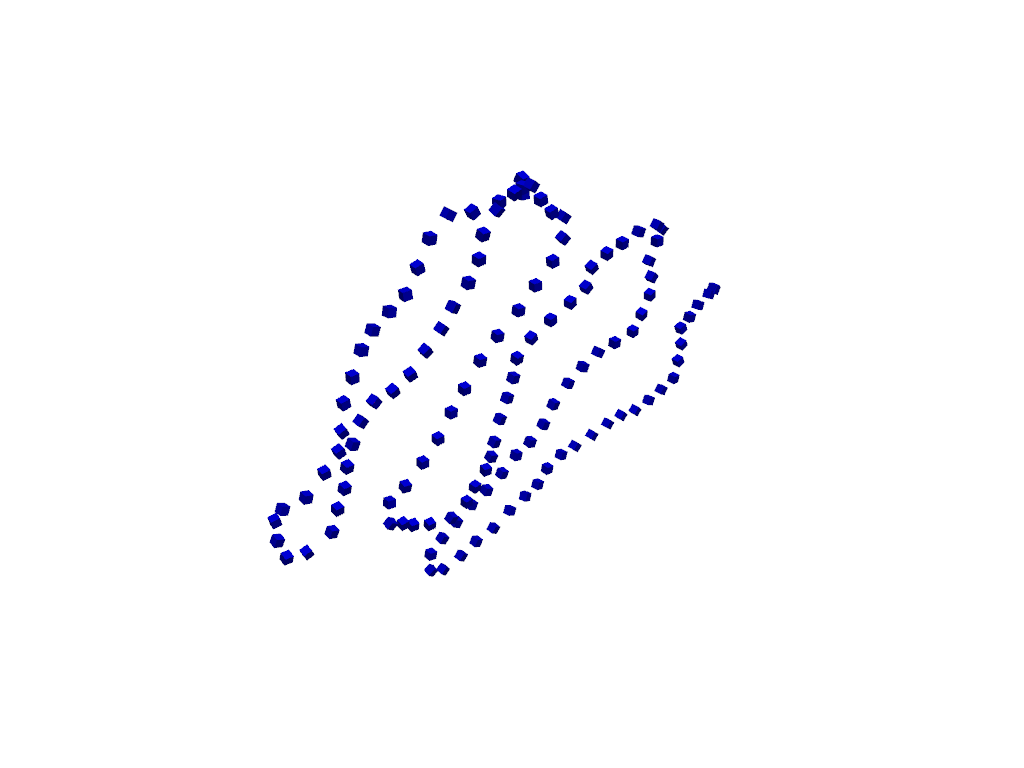

In [5]:
# The mesh must be loaded before visualizing cameras because of this bug:
# https://github.com/open-forest-observatory/geograypher/issues/203
camera_set.vis()

/ofo-share/repos-eric/geograypher/geograypher/meshes/meshes.py:2043: RuntimeWarning: invalid value encountered in cast
  vis_scalars = np.clip(vis_scalars, 0, 255).astype(np.uint8)


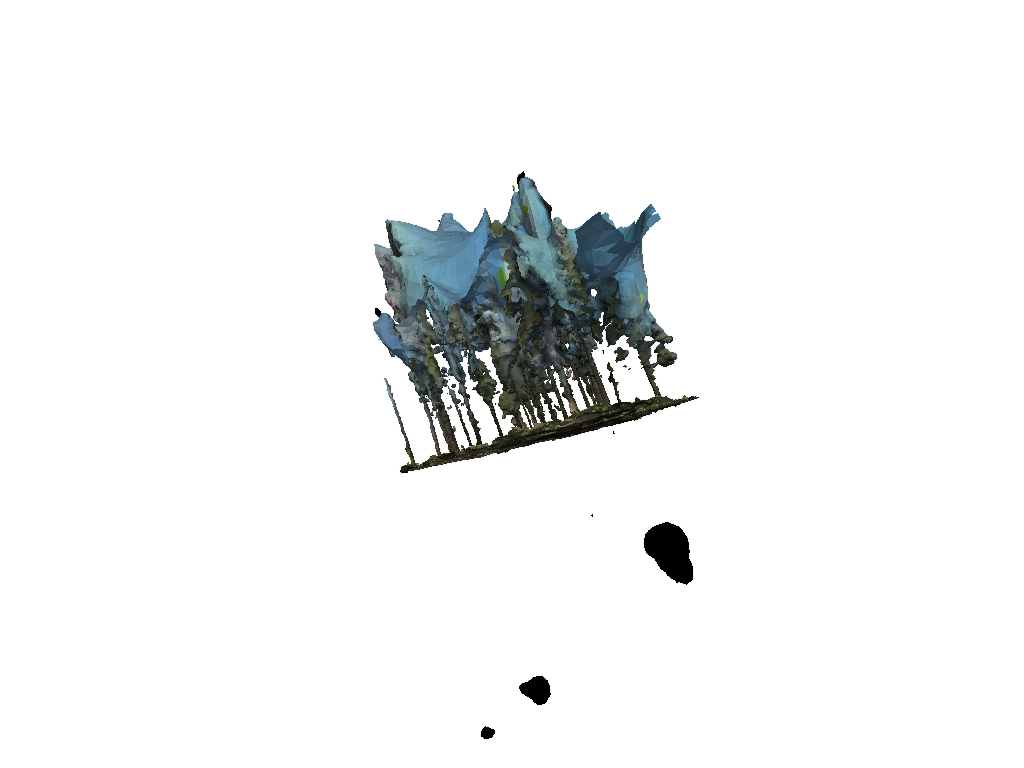

In [6]:
mesh.vis(camera_set=None, force_xvfb=True)

# Show the per-image predictions

Showing segmentation labels:   0%|          | 0/10 [00:00<?, ?it/s]

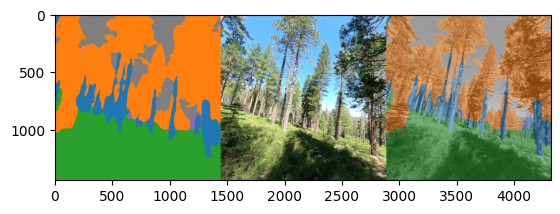

Showing segmentation labels:  10%|█         | 1/10 [00:01<00:09,  1.01s/it]

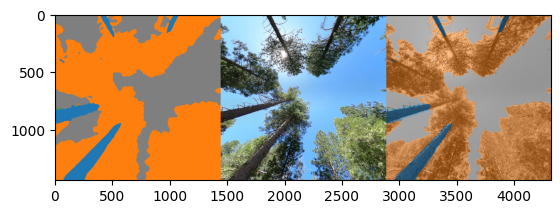

Showing segmentation labels:  20%|██        | 2/10 [00:01<00:07,  1.05it/s]

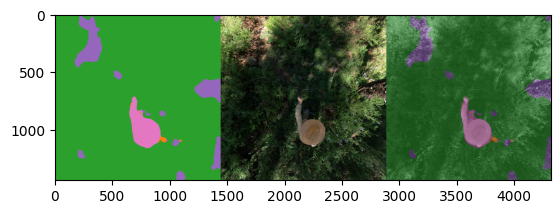

Showing segmentation labels:  30%|███       | 3/10 [00:02<00:06,  1.08it/s]

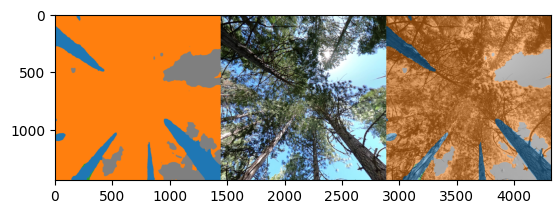

Showing segmentation labels:  40%|████      | 4/10 [00:03<00:05,  1.08it/s]

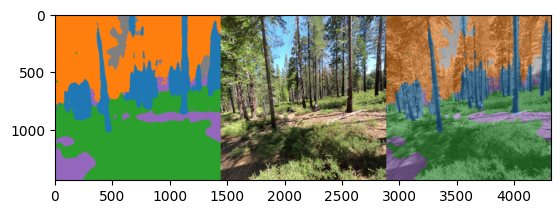

Showing segmentation labels:  50%|█████     | 5/10 [00:04<00:04,  1.07it/s]

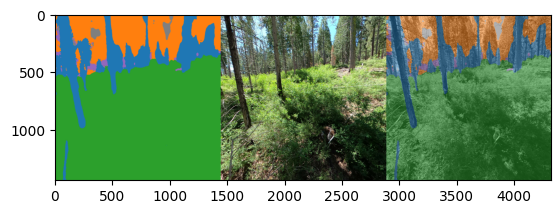

Showing segmentation labels:  60%|██████    | 6/10 [00:05<00:03,  1.08it/s]

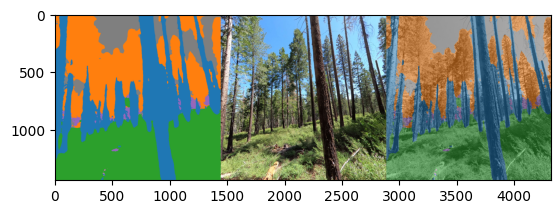

Showing segmentation labels:  70%|███████   | 7/10 [00:06<00:02,  1.07it/s]

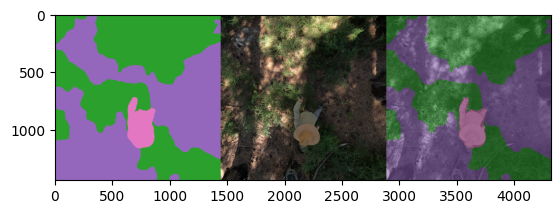

Showing segmentation labels:  80%|████████  | 8/10 [00:07<00:01,  1.08it/s]

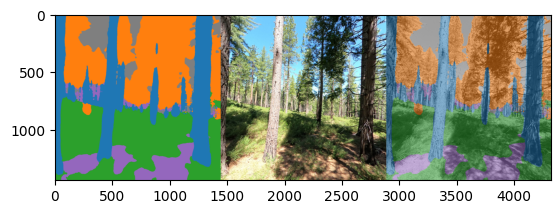

Showing segmentation labels:  90%|█████████ | 9/10 [00:08<00:00,  1.08it/s]

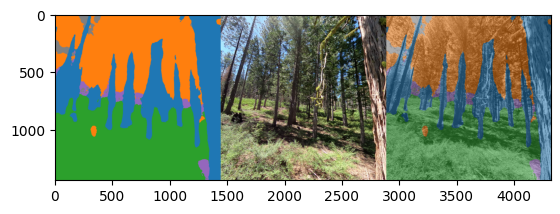

Showing segmentation labels: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


In [7]:
show_segmentation_labels(
    label_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    image_folder=IMAGE_FOLDER,
    IDs_to_labels=IDS_TO_LABELS,
    # NOTE: image suffix png is a temporary thing
    image_suffix=".png",
)

In [8]:
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=len(mesh.get_label_names()),
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    camera_set, segmentor=segmentor
)

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


In [9]:
if USE_CACHED_AGGREGATION and AGGREGATED_FACE_LABELS_FILE.is_file():
    aggregated_face_labels = np.load(AGGREGATED_FACE_LABELS_FILE)
else:
    aggregated_face_labels, _ = mesh.aggregate_projected_images(
        segmentor_camera_set,
        aggregate_img_scale=AGGREGATE_IMAGE_SCALE,
        apply_distortion=False,
    )
    np.save(AGGREGATED_FACE_LABELS_FILE, aggregated_face_labels)

Aggregating projected viewpoints: 100%|██████████| 756/756 [01:59<00:00,  6.31it/s]


In [10]:
predicted_face_classes = find_argmax_nonzero_value(aggregated_face_labels, keepdims=True)

# Show the projected and aggregated face predictions

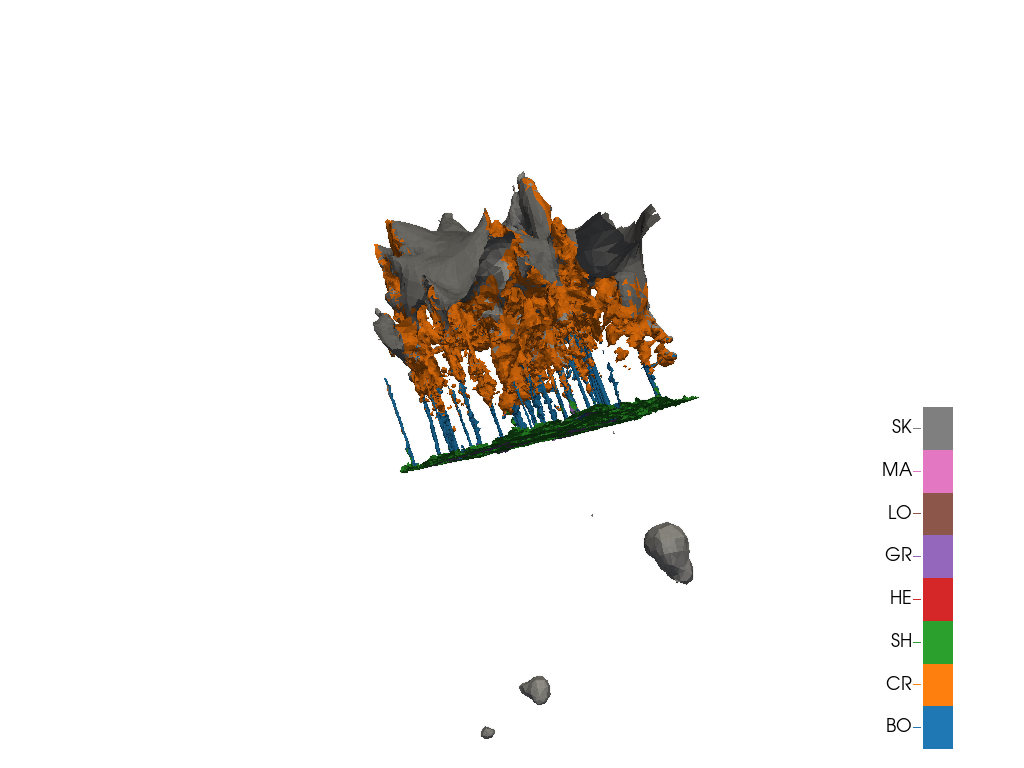

In [11]:
mesh.vis(vis_scalars=predicted_face_classes)

# Save the projected and aggregated face predictions as a mesh

In [12]:
pymesh = mesh.reproject_CRS(target_CRS=pyproj.CRS(26910), inplace=False)
pymesh.points -= np.array([763400, 4229800, 0])
assert pymesh.n_cells == len(predicted_face_classes)
del pymesh.point_data["RGB"]

colors = np.ones((pymesh.n_cells, 3))
cmap = plt.get_cmap("tab10")
for value in np.unique(predicted_face_classes):
    mask = predicted_face_classes.squeeze() == value
    colors[mask] = cmap(value / 10)[:3]
colors = (colors * 255).astype(np.uint8)

pymesh.cell_data["RGB"] = colors
pymesh.save(VIS_MESH_PATH, texture="RGB")

# Calculate the shrub volume

In [13]:
DTM_heights, verts_in_raster_CRS = mesh.get_vert_values_from_raster_file(DTM_FILE, return_verts_in_CRS=True)
height_above_ground = verts_in_raster_CRS[:, 2] - DTM_heights

Sampling values from raster /ofo-share/scratch-eric/tmp/automate-test-360-st0077_SHIFT/automate-test-360-st0077_dtm-ptcloud.tif: 100%|██████████| 54642/54642 [00:02<00:00, 22687.64it/s]


In [14]:
assert IDS_TO_LABELS[2] == "SH"
shrub = (predicted_face_classes == 2).squeeze()
# (N, 3) indices of the faces that have been marked "shrub"
shrub_face_indices = pymesh.faces.reshape((-1, 4))[:, 1:][shrub]

In [15]:
# Get the X and Y coordinates of each triangle
tri_x = verts_in_raster_CRS[:, 0][shrub_face_indices]
tri_y = verts_in_raster_CRS[:, 1][shrub_face_indices]

In [16]:
# Area of a triangle by vertices
# 0.5 * | x1(y2-y3) + x2(y3-y1) + x3(y1-y2) |
# https://www.omnicalculator.com/math/area-triangle-coordinates
areas = 0.5 * np.abs(
    tri_x[:, 0] * (tri_y[:, 1] - tri_y[:, 2]) +
    tri_x[:, 1] * (tri_y[:, 2] - tri_y[:, 0]) +
    tri_x[:, 2] * (tri_y[:, 0] - tri_y[:, 1])
)

In [17]:
# The volume between the top and bottom surfaces is
# Area of base × average height difference
avg_heights = height_above_ground[shrub_face_indices].mean(axis=1)
volumes = areas * avg_heights

In [18]:
print(f"I believe there is {volumes.sum():.1f} m³ of shrub volume")
print(f"\tAverage shrub triangle area: {areas.mean():.4f} m²")
print(f"\tAverage shrub triangle height: {avg_heights.mean():.4f} m")
print(f"\tNumber of shrub trangles: {len(volumes)}")

I believe there is 316.7 m³ of shrub volume
	Average shrub triangle area: 0.0456 m²
	Average shrub triangle height: 0.3232 m
	Number of shrub trangles: 23383


# Associate point cloud to labeled mesh

In [19]:
pcd_ply = pyvista.read(PCD_FILE)
pcd = np.asarray(pcd_ply.points, dtype=np.float64)

In [20]:
# Find the nearest neighbors for each point in the point cloud
nbrs = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(pymesh.points)
distances, indices = nbrs.kneighbors(pcd)
indices = indices.squeeze()

In [21]:
# Filter by distance (needs to be below a threshold) and class
mask_close = (distances < 0.25).squeeze()

In [22]:
assert IDS_TO_LABELS[0] == "BO"
trunk = (predicted_face_classes == 0).squeeze()
# (N, 3) indices of the faces that have been marked "trunk"
trunk_face_indices = pymesh.faces.reshape((-1, 4))[:, 1:][trunk]

In [23]:
# Filter by whether the closest point is connected to a shrub face (INEFFICIENT BUT WHATEVER FOR NOW)
mask_idx = np.zeros(mask_close.shape, dtype=bool)
for idx in tqdm(np.unique(trunk_face_indices)):
    mask_idx[indices == idx] = True

100%|██████████| 8567/8567 [01:06<00:00, 128.05it/s]


In [24]:
# Save the cloud
trunk_ply = pyvista.PolyData(pcd[mask_close & mask_idx])
trunk_ply.save(VIS_PCD_PATH)